# **Brain MRI Segmentation using Spatial Attention UNet (SA-UNet)**

This Jupyter Notebook details the implementation and evaluation of a specialized deep learning model, SA-UNet for the task of brain MRI segmentation. The objective is to accurately segment brain MRIs, which is crucial for medical diagnosis and treatment planning. The SA-UNet model leverages the U-Net architecture with an added spatial attention mechanism, enhancing its ability to focus on relevant features in MRI images. This notebook includes data preprocessing, model building, training, and evaluation steps, providing a comprehensive view of the project.

## **Mounting Google Drive**

Mount the Google Drive to load the dataset and any other resources stored in the drive. Navigate to the folder where dataset is stored.

In [1]:
import os

# Set the path to your dataset directory
dataset_dir = '/Users/pascal/Desktop/archive/kaggle_3m'




In [2]:
!ls  '/Users/pascal/Desktop/archive/kaggle_3m'



README.md             TCGA_DU_7019_19940908 TCGA_FG_A60K_20040224
TCGA_CS_4941_19960909 TCGA_DU_7294_19890104 TCGA_HT_7473_19970826
TCGA_CS_4942_19970222 TCGA_DU_7298_19910324 TCGA_HT_7475_19970918
TCGA_CS_4943_20000902 TCGA_DU_7299_19910417 TCGA_HT_7602_19951103
TCGA_CS_4944_20010208 TCGA_DU_7300_19910814 TCGA_HT_7605_19950916
TCGA_CS_5393_19990606 TCGA_DU_7301_19911112 TCGA_HT_7608_19940304
TCGA_CS_5395_19981004 TCGA_DU_7302_19911203 TCGA_HT_7616_19940813
TCGA_CS_5396_20010302 TCGA_DU_7304_19930325 TCGA_HT_7680_19970202
TCGA_CS_5397_20010315 TCGA_DU_7306_19930512 TCGA_HT_7684_19950816
TCGA_CS_6186_20000601 TCGA_DU_7309_19960831 TCGA_HT_7686_19950629
TCGA_CS_6188_20010812 TCGA_DU_8162_19961029 TCGA_HT_7690_19960312
TCGA_CS_6290_20000917 TCGA_DU_8163_19961119 TCGA_HT_7692_19960724
TCGA_CS_6665_20010817 TCGA_DU_8164_19970111 TCGA_HT_7693_19950520
TCGA_CS_6666_20011109 TCGA_DU_8165_19970205 TCGA_HT_7694_19950404
TCGA_CS_6667_20011105 TCGA_DU_8166_19970322 TCGA_HT_7855_19951020
TCGA_CS_66

## **Importing Necessary Libraries and Modules**

In this section, we import all the necessary libraries and modules required for our brain MRI segmentation project.

In [1]:
import os

import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Multiply, Lambda, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## **Understanding the Dataset**

Here, we load the metadata from the data.csv file, which is an integral part of our brain MRI dataset. This file contains important information about the MRI images and their corresponding labels. Understanding the metadata is crucial for preprocessing and analysis.

In [1]:
import pandas as pd
# Load the data.csv to understand the metadata
data_csv_path = '/Users/pascal/Desktop/archive/kaggle_3m/data.csv'
data_df = pd.read_csv(data_csv_path)

# Display the first few rows of the dataframe
print(data_df.head())

        Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0  

## **Data Visualization**

Visualize the MRI images along with their corresponding masks. This step is crucial for understanding how the segmentation masks are applied to the brain MRI images. Visualization helps in assessing the quality of the data and the masks, which is essential for verifying the accuracy of our segmentation model.

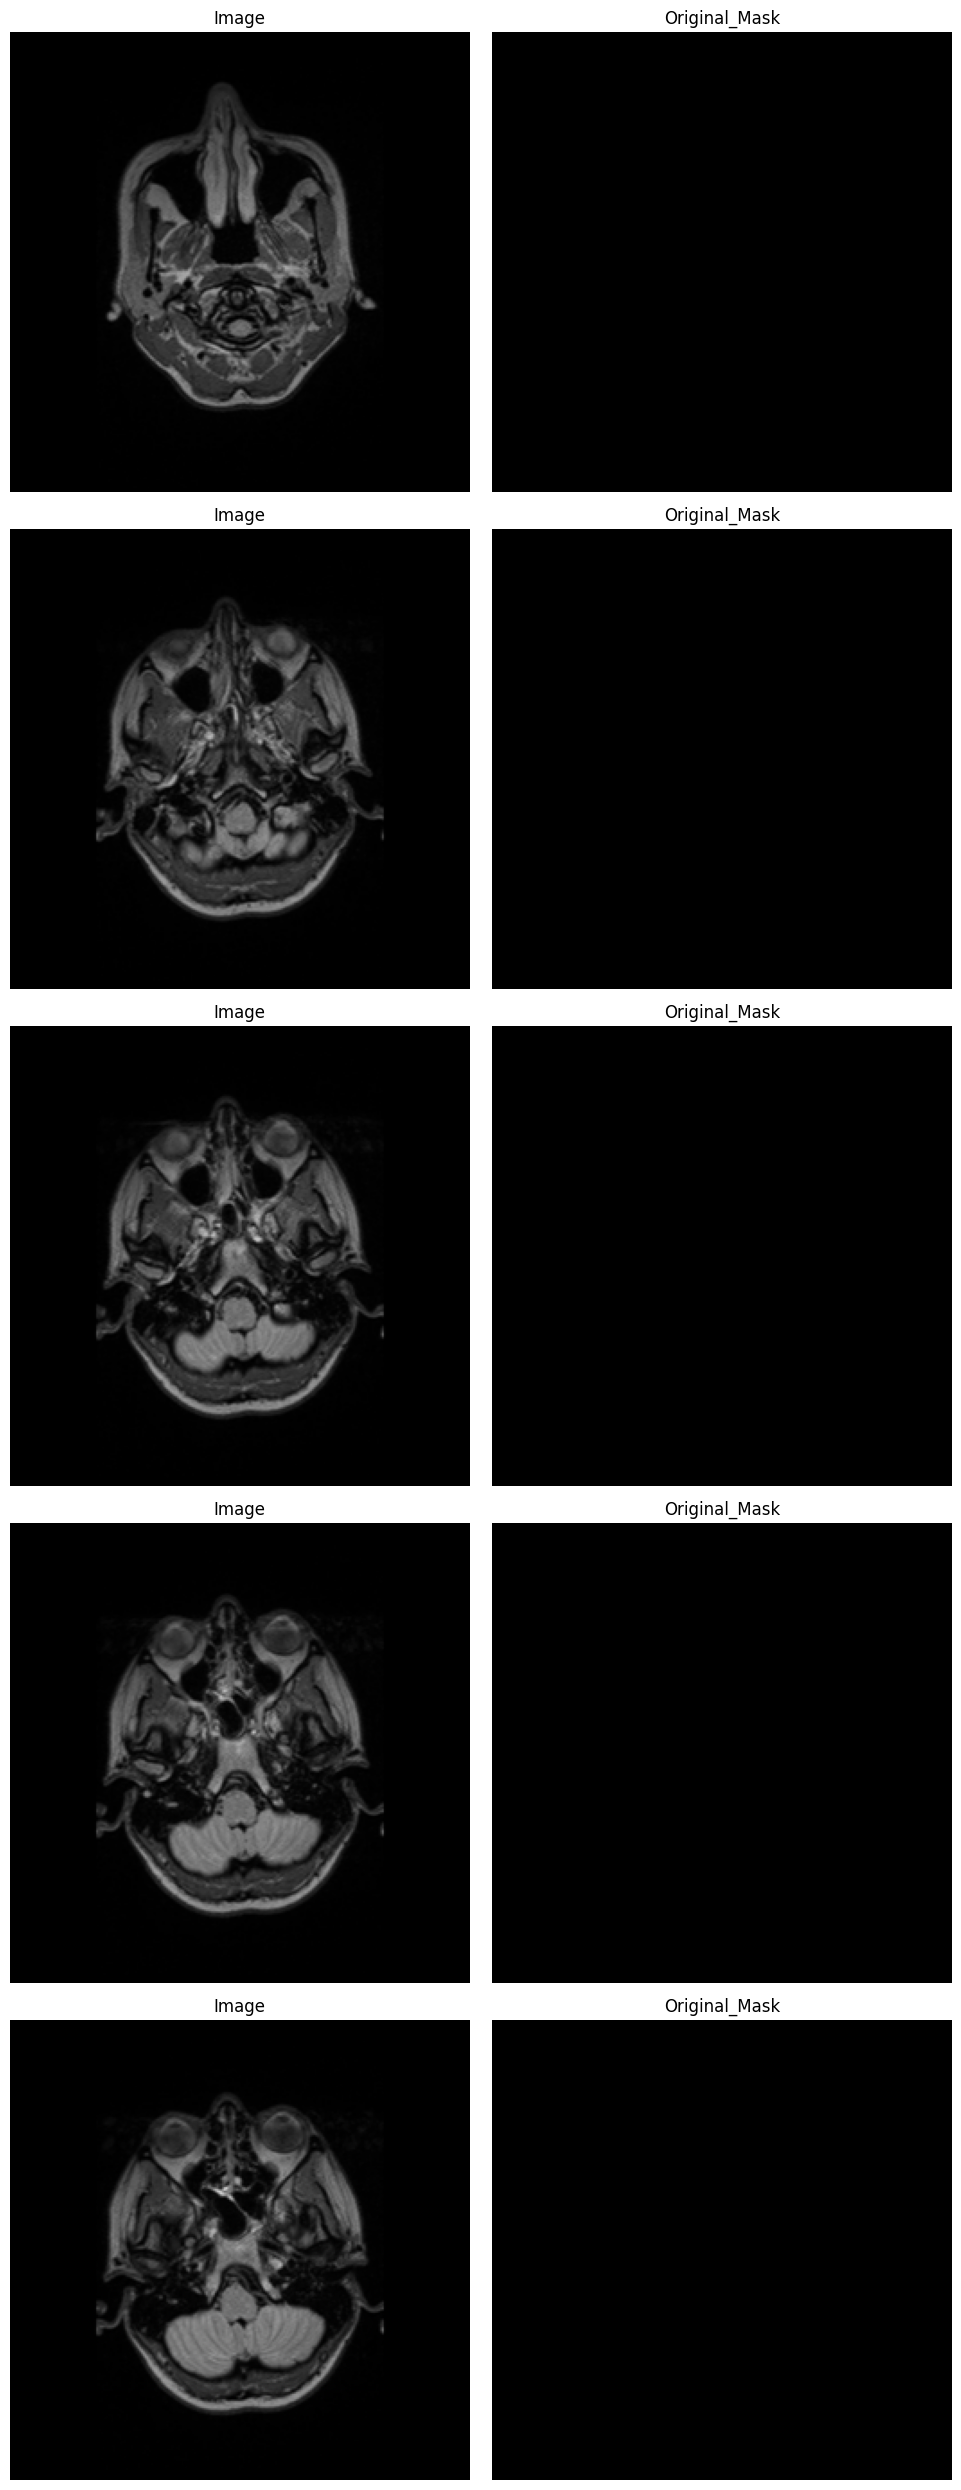

In [2]:
import os
import cv2
from matplotlib import pyplot as plt

def load_images_with_masks(base_dir, patient_id, num_samples=5):
    patient_path = os.path.join(base_dir, patient_id)
    image_files = [f for f in os.listdir(patient_path) if not f.endswith('_mask.tif')]
    image_files = sorted(image_files)[:num_samples]  # Limit the number of samples for visualization

    images = []
    masks = []

    for img_file in image_files:
        img_path = os.path.join(patient_path, img_file)
        mask_path = os.path.join(patient_path, img_file.replace('.tif', '_mask.tif'))

        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)

    return images, masks

def visualize_images_and_masks(images, masks):
    plt.figure(figsize=(10, 5 * len(images)))
    for i, (image, mask) in enumerate(zip(images, masks)):
        plt.subplot(len(images), 2, 2*i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(len(images), 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Original_Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

base_dir = '/Users/pascal/Desktop/archive/kaggle_3m'
patient_id = 'TCGA_FG_A60K_20040224'

images, masks = load_images_with_masks(base_dir, patient_id)
visualize_images_and_masks(images, masks)

## **Counting the Total Number of Images in the Dataset**

In [3]:
def count_total_images_and_masks(base_dir):
    total_images = 0
    total_masks = 0

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tif') and '_mask' not in file:
                total_images += 1
            elif '_mask.tif' in file:
                total_masks += 1

    return total_images, total_masks

base_dir = '/Users/pascal/Desktop/archive/kaggle_3m'
total_images, total_masks = count_total_images_and_masks(base_dir)
print(f"Total number of images: {total_images}")
print(f"Total number of masks: {total_masks}")

Total number of images: 3929
Total number of masks: 3929


## **Data Preprocessing**

This step involves dividing our dataset into three distinct sets: training (85%), validation (10%), and test (5%). This division is critical for effective model training and evaluation

In [4]:
from sklearn.model_selection import train_test_split
def get_image_mask_pairs(base_dir):
    all_images = []
    all_masks = []

    for root, dirs, files in os.walk(base_dir):
        for file in sorted(files):
            if file.endswith('.tif') and not file.endswith('_mask.tif'):
                image_path = os.path.join(root, file)
                mask_path = os.path.join(root, file.replace('.tif', '_mask.tif'))

                if os.path.exists(mask_path):  # Ensure the mask exists
                    all_images.append(image_path)
                    all_masks.append(mask_path)

    return all_images, all_masks

base_dir = '/Users/pascal/Desktop/archive/kaggle_3m'
all_images, all_masks = get_image_mask_pairs(base_dir)

# Initial split: 85% for training, 15% for temp (to be split further into validation and test)
train_images, temp_images, train_masks, temp_masks = train_test_split(all_images, all_masks, test_size=0.15, random_state=42)

# Split the temp data into validation and test sets
# Since temp is 15% of the whole, validation is 10% of the whole (about 2/3 of temp), and test is 5% of the whole (about 1/3 of temp)
validation_images, test_images, validation_masks, test_masks = train_test_split(temp_images, temp_masks, test_size=1/3, random_state=42)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(validation_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 3339 images
Validation set: 393 images
Test set: 197 images


In [5]:
# Convert lists into DataFrames
df_train = pd.DataFrame({'image_path': train_images, 'mask_path': train_masks})
df_validation = pd.DataFrame({'image_path': validation_images, 'mask_path': validation_masks})
df_test = pd.DataFrame({'image_path': test_images, 'mask_path': test_masks})

## **Setting Up the Training Data Generator**

The generator applies real-time data augmentation techniques to the dataset during model training, including rotations, shifts, flips, and more. Such augmentations help in improving the model's robustness by simulating various conditions and orientations of MRI images. The generator also handles the efficient loading and processing of images in batches, which is crucial for training deep learning models on large datasets without overloading the memory.

In [6]:
def normalize_data(img, mask):
    # Implement your normalization logic here
    return img, mask

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    # Create generators for images and masks
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_path",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask_path",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_data(img, mask)
        yield (img, mask)

## **Data Normalization**

Normalization is a crucial preprocessing step in deep learning as it scales the pixel intensity values to a standard range, typically between 0 and 1. This process helps in stabilizing the training process and improving model convergence

In [7]:
def normalize_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

## **Loss Function and Evaluation Metrics**

Here we define the loss function and metrics that will be used to train and evaluate our model.

**Dice Coefficient Loss:** A custom loss function based on the Dice coefficient, which is effective for segmentation tasks as it measures the overlap between the predicted and actual masks.

**Evaluation Metrics:** These include accuracy, Intersection over Union (IoU), and Dice coefficient. These metrics provide insights into various aspects of the model's performance, from general accuracy to specific overlap between the predicted and true segmentation areas.

In [8]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

## **Defining Encoder and Decoder Blocks for the SA-UNet Model**

**Encoder Blocks:** Each block comprises convolutional layers followed by dropout, batch normalization, relu and max pooling for downsampling.

**Spatial Attention block:** It applies both max pooling and average pooling across the channel dimension to capture different aspects of the spatial features, concatenate their outputs, normalize by sigmoid activation and multiply with input feature map to generate attention map.

**Decoder Blocks:** Each decoder block starts with a transposed convolution for upsampling, followed by concatenation with the corresponding encoder output (skip connection), and convolutional layers similar to those in the encoder.

In [9]:
def encoder_block(input_tensor, num_filters, dropout_rate=0.2):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    p = MaxPooling2D((2, 2))(x)
    return x, p

def spatial_attention_block(input_tensor):
    max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
    avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)

    concat = tf.concat([max_pool, avg_pool], axis=-1)
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    output = Multiply()([input_tensor, attention])

    return output

def decoder_block(input_tensor, skip_features, num_filters, dropout_rate=0.2):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, skip_features])

    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

## **Defining the  Spatial Attention U-Net Architecture**

In [10]:
img_width, img_height = 256, 256
def unet_model(input_shape = (img_width, img_height, 3)):
  inputs = Input(input_shape)

  # Encoder
  e1, p1 = encoder_block(inputs, 16, 0.2)
  e2, p2 = encoder_block(p1, 32, 0.2)
  e3, p3 = encoder_block(p2, 64, 0.2)
  e4, p4 = encoder_block(p3, 128, 0.2)

  # Spatial Attention
  sa = spatial_attention_block(p4)

  # Decoder
  d1 = decoder_block(sa, e4, 128, 0.2)
  d2 = decoder_block(d1, e3, 64, 0.2)
  d3 = decoder_block(d2, e2, 32, 0.2)
  d4 = decoder_block(d3, e1, 16, 0.2)

  # Output
  outputs = Conv2D(filters=1, kernel_size =(1, 1), activation='sigmoid')(d4)

  return Model(inputs=[inputs], outputs = [outputs])

## **Setting Up Training Parameters and Data Augmentation**

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def normalize_data(img, mask):
    # Implement your normalization logic here
    return img, mask

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    # Create generators for images and masks
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_path",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask_path",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_data(img, mask)
        yield (img, mask)

# Rest of your code
epochs = 50
batch_size = 32
lr = 1e-4

train_generator_args = dict(
    rotation_range=0.25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_generator(df_train, batch_size, train_generator_args)
test_gen = train_generator(df_test, batch_size, dict())

model = unet_model(input_shape=(256, 256, 3))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])
callbacks = [
    ModelCheckpoint('unet_model.hdf5', verbose=1, save_best_only=True)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_validation) / batch_size
)

In [1]:
import pandas as pd
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

df_train = pd.read_csv('/Users/pascal/Desktop/archive/kaggle_3m/data.csv')
df_test = pd.read_csv('/Users/pascal/Desktop/archive/kaggle_3m/data.csv')
epochs = 10
batch_size = 16
lr = 1e-4

train_generator_args = dict(
    rotation_range=0.25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_generator(df_train, batch_size, train_generator_args)
test_gen = train_generator(df_test, batch_size, dict())

model = unet_model(input_shape=(256, 256, 3))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])
callbacks = [
    ModelCheckpoint('unet_model.hdf5', verbose=1, save_best_only=True)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_test) / batch_size
)



## **Visualize the Model**

In [1]:
from tensorflow import keras
keras.utils.plot_model(model, to_file = "Model.png", show_shapes=True)

## **Plotting Loss and Accuracy Graphs**





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint

# Assuming you have defined your data generators train_gen and test_gen
# and have loaded your training and testing data into df_train and df_test
# Define your data generators and other necessary variables

# Example data
df_train = pd.DataFrame()
df_test = pd.DataFrame()
train_gen = None  # Define your train generator
test_gen = None  # Define your test generator
batch_size = 32
epochs = 10

# Define your model
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Example input shape
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks if needed
# Example checkpoint callback to save the best model during training
# callbacks = [ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) / batch_size,
    epochs=epochs,
    # callbacks=callbacks,  # Uncomment this line if you have callbacks
    validation_data=test_gen,
    validation_steps=len(df_test) / batch_size
)

# Visualize training history
history_training = history.history

train_loss_list = history_training['loss']
test_loss_list = history_training['val_loss']
train_accuracy_list = history_training['accuracy']
test_accuracy_list = history_training['val_accuracy']

# Plot loss
plt.plot(train_loss_list, 'r-', label='Train Loss')
plt.plot(test_loss_list, 'b-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracy_list, 'r-', label='Train Accuracy')
plt.plot(test_accuracy_list, 'b-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


## **Load Model**

In [1]:
from keras.models import load_model

model = load_model('unet_model.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients})

## **Model Evaluation**

In [1]:
import pandas as pd
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Load the training and test data
df_train = pd.read_csv('/Users/pascal/Desktop/archive/kaggle_3m/data.csv')
df_test = pd.read_csv('/Users/pascal/Desktop/archive/kaggle_3m/data.csv')

epochs = 10
batch_size = 16
lr = 1e-4

train_generator_args = dict(
    rotation_range=0.25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_generator(df_train, batch_size, train_generator_args)
test_gen = train_generator(df_test, batch_size, dict(), target_size=(256, 256))

model = unet_model(input_shape=(256, 256, 3))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])
callbacks = [
    ModelCheckpoint('unet_model.hdf5', verbose=1, save_best_only=True)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_test) / batch_size
)

# Evaluate the model on the test set
results = model.evaluate(test_gen, steps=len(df_test) / batch_size)
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

## **Visualize Predictions**

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have loaded your test dataset into a DataFrame named df_test
# Define df_test with sample data for demonstration
df_test = pd.DataFrame({
    'image_path': [],
    'mask_path': []
})

for i in range(20):
    if len(df_test.index) > 0:
        index = np.random.randint(0, len(df_test.index))
        img_path = df_test['image_path'].iloc[index]
        mask_path = df_test['mask_path'].iloc[index]

        # Read and preprocess the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (256, 256))
        img_normalized = img_resized / 255.0
        img_expanded = np.expand_dims(img_normalized, axis=0)

        # Generate the prediction
        pred_mask = model.predict(img_expanded)
        pred_mask_thresholded = (pred_mask.squeeze() > 0.5).astype(np.float32)

        # Read and preprocess the mask
        original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        original_mask_resized = cv2.resize(original_mask, (256, 256))
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Display the original image
        axs[0].imshow(img_resized)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Display the original mask
        axs[1].imshow(original_mask_resized, cmap='gray')
        axs[1].set_title("Original Mask")
        axs[1].axis('off')

        # Display the predicted mask
        axs[2].imshow(pred_mask_thresholded, cmap='gray')
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        plt.show()
    else:
        print("df_test is empty, no more images to process.")
        break

df_test is empty, no more images to process.


In [1]:
import pandas as pd
from keras.models import model


# Train your model with the fit() method
history = model.fit()

# Create a DataFrame from the training history
hist_df = pd.DataFrame(history.history)

# Save to JSON
hist_json_file = 'history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Save to CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
